In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [34]:
class particle_array():
    def __init__(self, n, dims):
        self.lbound = dims[0]
        self.ubound = dims[1]
        self.llimit = dims[2]
        self.ulimit = dims[3]
        particle_spacing = np.linspace(self.lbound, self.ubound, n, dtype = float)
        particle_array = np.array(np.meshgrid(particle_spacing, particle_spacing, particle_spacing)).T.reshape(-1,3)
        self.particles = [particle(coordinates, 
                                   [0, 0, 0]) for coordinates in particle_array]
        self.calc_density()
        self.calc_pressure()
        self.calc_accel()
        self.calc_veloc()
            
    def get_specific_pos(self, n):
        return self.particles[n].p
    def get_position(self):
        for particle in self.particles:
            print(particle.p)
            
    def get_specific_direction(self,n):
        return self.particles[n].d
    def get_direction(self):
        for particle in self.particles:
            print(particle.d)
            
    def get_initrho(self):
        for particle in self.particles:
            print(particle.initrho)
    def get_initpre(self):
        for particle in self.particles:
            print(particle.initpre)
    def get_rho(self):
        for particle in self.particles:
            print(particle.rho)
            
    def get_specific_pressure(self, n):
        return self.particles[n].pre
    def get_pre(self):
        for particle in self.particles:
            print(particle.pre)
            
    def get_specific_accel(self, n):
        return self.particles[n].a
    def get_accel(self):
        for particle in self.particles:
            print(particle.a)
    def get_veloc(self):
        for particle in self.particles:
            print(particle.d)
            
    def calc_accel(self):
        for particle_1 in self.particles:
            #total = 0
            temporary = np.array([0, 0, 0], dtype = float)
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    #total += (particle_2.m)*\
                    #((particle_1.pre / (particle_1.rho ** 2)) + (particle_2.pre / (particle_2.rho ** 2))) *\
                    #(pairwise_calculator(particle_1, particle_2).dgaus_kern())
                    
                    temporary += (particle_2.m)*\
                    ((particle_1.pre / (particle_1.rho ** 2)) + (particle_2.pre / (particle_2.rho ** 2))) *\
                    (pairwise_better(particle_1, particle_2).dgaus_kern())
            particle_1.a = -1 * temporary
            
    def calc_veloc(self):
        for particle in self.particles:
            for i in range(3):
                if i == 2:
                    potential_speed = (particle.dt * particle.a[i]) - (particle.dt * particle.g)
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                else:
                    potential_speed = (particle.dt * particle.a[i])
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                        
    def move(self):
        for particle in self.particles:
            potential_positions = particle.p.copy()
            for i in range(3):
                potential_positions[i] += particle.d[i] * particle.dt
                if potential_positions[i] < self.llimit:
                    potential_positions[i] = self.llimit
                    particle.d[i] *= -1
                elif potential_positions[i] > self.ulimit:
                    potential_positions[i] = self.ulimit
                    particle.d[i] *= -1
                particle.p = potential_positions
                
    def calc_density(self):
        for particle_1 in self.particles:
            #total = 0      # I changed this to 1 cus it shld be wrt ur initial density?
            temporary = np.array([0,0,0], dtype = float)
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                #    total += particle_2.m * pairwise_calculator(particle_1, particle_2).gaus_kern()
                    temporary += particle_2.m * pairwise_better(particle_1, particle_2).gaus_kern()
                particle_1.rho = temporary
                
    def calc_pressure(self):
        for particle in self.particles:
            particle.pre = (((0.01**2) * 1)/7) * ((particle.rho / 1)**7 - 1)    # i dont rmb what i did but i played with the values here
            

In [35]:
class particle():
    def __init__(self, position, direction):
        self.p = position
        self.d = direction
        self.m = 1
        self.dt = 0.5 #s
        self.initrho = 1
        self.rho = 0
        self.pre = 0
        self.vmax = 10
        self.a = 0
        self.g = 9.81
    
    def get_magnitude(self):
        x, y, z = self.p
        return ((x**2) + (y**2) + (z**2))**(1/2)
        #return np.linalg.norm(self.p) This one works too

In [36]:
class pairwise_calculator():
    def __init__(self, particle1, particle2):
        self.p1 = particle1
        self.p2 = particle2
        
    def gaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return ((1 / h*(np.pi**(1/2)))**d) * (np.e**(-(delta_mag**2) / (h**2)))
    
    def dgaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return -((2*np.e**(-(delta_mag**2) / (h**2)))*(delta_mag)) / ((h**5)*(np.pi*(3/2)))

In [43]:
class pairwise_better():
    def __init__(self, particle1, particle2):
        self.p1 = particle1
        self.p2 = particle2
    
    def gaus_kern(self, h = 1, d = 1):
        temporary_list = []
        for i,j in zip(self.p1.p, self.p2.p):
            temporary_list.append(((1 / h*(np.pi**(1/2)))**d) * (np.e**(-((i-j)**2) / (h**2))))
        return np.array(temporary_list, dtype = float)
    
    def dgaus_kern(self, h = 1, d=1):
        temporary_list = []
        for i,j in zip(self.p1.p, self.p2.p):
            temporary_list.append(-((2*np.e**(-((i-j)**2) / (h**2)))*(i-j)) / ((h**(2+d))*(np.pi*(d/2))))
        return np.array(temporary_list, dtype = float)

In [45]:
my_particles = particle_array(3, [0, 10, 0, 20])

for i in range(50):
    print("position = " + str(my_particles.get_specific_pos(0)))
    #print("velocity = " + str(my_particles.get_specific_direction(0)))
    #print("acc = " + str(my_particles.get_specific_accel(0)))
    #print("pressure = " + str(my_particles.get_specific_pressure(0)))
    my_particles.move()
    my_particles.calc_density()
    my_particles.calc_pressure()
    my_particles.calc_accel()
    my_particles.calc_veloc()

position = [0. 0. 0.]
position = [0. 0. 0.]
position = [0. 0. 0.]
position = [0. 0. 0.]
position = [0. 0. 0.]
position = [0.     0.     2.5475]
position = [6.74152199e-23 6.74152199e-23 2.64250000e+00]
position = [0.         0.         0.28499999]
position = [1.36898391e-22 1.36898391e-22 0.00000000e+00]
position = [0. 0. 0.]
position = [2.47327003e-22 2.60561893e-22 2.54750000e+00]
position = [0.     0.     2.6425]
position = [1.08402019e-21 4.88450152e-22 2.85000000e-01]
position = [0. 0. 0.]
position = [0.00000000e+00 7.37431516e-22 0.00000000e+00]
position = [0.     0.     2.5475]
position = [4.42849339e-19 1.13447821e-21 2.64250000e+00]
position = [0.    0.    0.285]
position = [0.00000000e+00 1.58694601e-21 0.00000000e+00]
position = [0. 0. 0.]
position = [1.94697291e-16 2.21353532e-21 2.54750000e+00]
position = [0.     0.     2.6425]
position = [0.00000000e+00 2.89058265e-21 2.85000000e-01]
position = [0. 0. 0.]
position = [8.54839238e-14 3.82488315e-21 0.00000000e+00]
position 

In [60]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


#Creation of my particle
plot_particles = particle_array(n=8, dims=[30, 40, 0, 40])
duration = 1
dt = 0.01
table = {}
def memoize():
    global table, duration, dt
    step = 0
    while step <=duration:
        plot_particles.move()
        plot_particles.calc_density()
        plot_particles.calc_pressure()
        plot_particles.calc_accel()
        plot_particles.calc_veloc()
        temp = []
        for particle in plot_particles.particles:
            temp.append(list(particle.p))
        table[step] = temp
        step += dt
    return table
memoize()

{0: [[25.0, 25.0, 25.0],
  [25.0, 26.428571428571427, 25.0],
  [25.0, 27.857142857142854, 25.0],
  [25.0, 29.285714285714285, 25.0],
  [25.0, 40.0, 25.0],
  [25.0, 40.0, 25.0],
  [25.0, 40.0, 25.0],
  [25.0, 40.0, 25.0],
  [26.428571428571427, 25.0, 25.0],
  [26.428571428571427, 26.428571428571427, 25.0],
  [26.428571428571427, 27.857142857142854, 25.0],
  [26.428571428571427, 29.285714285714285, 25.0],
  [26.428571428571427, 40.0, 25.0],
  [26.428571428571427, 40.0, 25.0],
  [26.428571428571427, 40.0, 25.0],
  [26.428571428571427, 40.0, 25.0],
  [27.857142857142854, 25.0, 25.0],
  [27.857142857142854, 26.428571428571427, 25.0],
  [27.857142857142854, 27.857142857142854, 25.0],
  [27.857142857142854, 29.285714285714285, 25.0],
  [27.857142857142854, 40.0, 25.0],
  [27.857142857142854, 40.0, 25.0],
  [27.857142857142854, 40.0, 25.0],
  [27.857142857142854, 40.0, 25.0],
  [29.285714285714285, 25.0, 25.0],
  [29.285714285714285, 26.428571428571427, 25.0],
  [29.285714285714285, 27.8571428

<IPython.core.display.Javascript object>


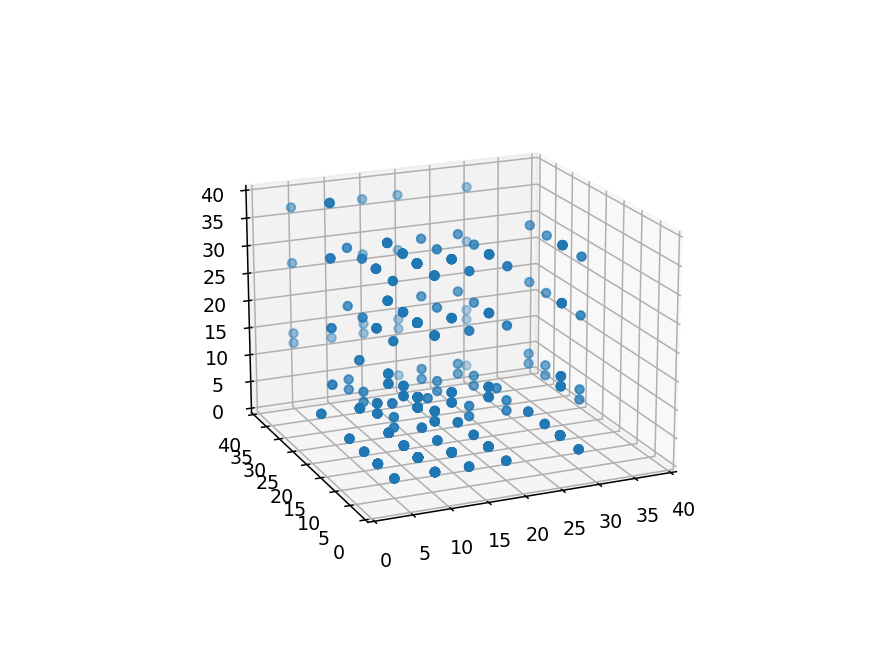

In [64]:
##############################################################
#The creation of my figure                                   #
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

my_timer = 0
dt = 0.01

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([0, 40])
    ax.set_ylim3d([0, 40])
    ax.set_zlim3d([0, 40])
    scat = ax.scatter(
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    return scat,


def animate(frame):
    global my_timer, dt
        
    scat._offsets3d = (
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    my_timer += dt
    return scat,


ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=True)
plt.show()